In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle

Started by initializing all imports

In [4]:
corn_yields = pd.read_csv('Processed_Data/corn_yields_processed.csv')

There are only 25 unique values as each feature here has only 25 values since they are all averages for one year from years 2000-2024

In [32]:
data = corn_yields

In [25]:
# Check for outliers
Q1 = data['YIELD'].quantile(0.25)
Q3 = data['YIELD'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['YIELD'] < Q1 - 1.5*IQR) | (data['YIELD'] > Q3 + 1.5*IQR)]
print("\nYIELD Outliers:")
print(outliers)


YIELD Outliers:
     YIELD  AVG_PRECIPITATION  AVG_TEMPERATURE  AVG_WETNESS
124   96.5            1.90875        24.485937     0.504062
129   97.4            1.90875        24.485937     0.504062


I checked here to see if there were any significant outlier that may need to be removed, but they were not significant enough to count as bad data

In [26]:
# Define features and target
X = data[['AVG_PRECIPITATION', 'AVG_TEMPERATURE', 'AVG_WETNESS']]
y = data['YIELD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

I split my data into a train test split of ratio 80:20. I then set up my parameter that I would optimize by giving numerous combinations to try.

In [27]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validated R squared:", grid_search.best_score_)
# Train with best parameters


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validated R squared: 0.8538423265700696


Here I used a scikit-learn hyperparameter tuning pipeline using grid search with cross-validation for a RandomForestRegressor model. This allowed me to find the hyperparameters that would give me the highest R^2 score

In [28]:
rf_model = grid_search.best_estimator_

I assign the model I will use here as the one that was the best estimator by grid search

In [29]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R squared Score: {r2:.2f}")

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Model Performance:
Mean Squared Error (MSE): 98.08
Root Mean Squared Error (RMSE): 9.90
R squared Score: 0.90

Feature Importance:
AVG_WETNESS          0.557322
AVG_PRECIPITATION    0.237204
AVG_TEMPERATURE      0.205474
dtype: float64


I then here check the accuracy of my model by seeing it's scores on my test set. I utilize mean squared error, root mean squared error, and r squared to gauge the accuracy of my model. I also then check what importance the model has assigned to each feature to determine what factor affects corn yields the most.


Predicted YIELD: 203.42


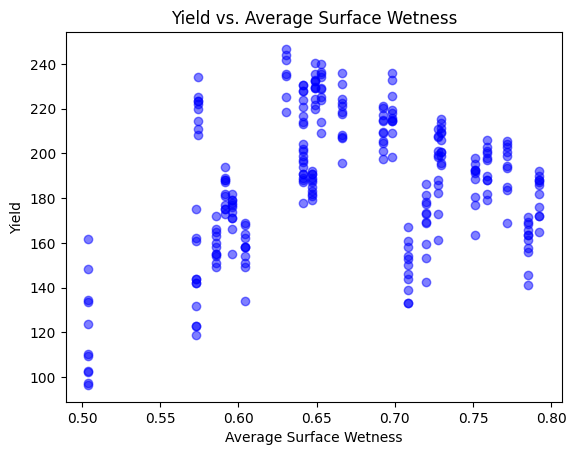

In [30]:
# Predict new data
new_data = pd.DataFrame({
    'AVG_PRECIPITATION': [3.131563],
    'AVG_TEMPERATURE': [21.406562],
    'AVG_WETNESS': [0.73]
})
prediction = rf_model.predict(new_data)
print(f"\nPredicted YIELD: {prediction[0]:.2f}")

# Plot YIELD vs. AVG_PRECIPITATION
plt.scatter(X['AVG_WETNESS'], y, color='blue', alpha=0.5)
plt.xlabel('Average Surface Wetness')
plt.ylabel('Yield')
plt.title('Yield vs. Average Surface Wetness')
plt.show()

I took the trained random forest model and gave it new climate data (average precipitation, temperature, and wetness) to see what yield it would predict. Then I plotted a scatter chart of historical yields versus average precipitation so I can visually check if the prediction makes sense compared to past data.

In [31]:
with open("models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

I save the random forest model as a pkl file here